In [19]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

print(tf.__version__)


2.10.0


In [20]:

# Load the data into a pandas dataframe
data_path = "../data/malware_dataset.csv"
data = pd.read_csv(data_path)

# Convert classification column from string values into numerical values
# 0 - malware , 1 - benign
le = LabelEncoder()
data["classification"] = le.fit_transform(data["classification"])

# Drop the classification from input data and pass it in as output
features = data.drop(columns=["classification"])

print(features.shape)

# Perform PCA to reduce dimensionaliy
# ty
pca = PCA(n_components=34)
features = pca.fit_transform(features)

# Normalize features
# Mean of 0 and Standard deviation of 1 to highlight large features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    features, data["classification"], test_size=0.2, random_state=42)


enc = OneHotEncoder()
train_labels = enc.fit_transform(train_labels.values.reshape(-1, 1)).toarray()
test_labels = enc.transform(test_labels.values.reshape(-1, 1)).toarray()


(100000, 34)


In [21]:
# PCA "n_components" output
input_dim = 34

input_layer = tf.keras.layers.Input(shape=(input_dim,))
encoder = tf.keras.layers.Dense(64, activation='relu')(input_layer)
encoder = tf.keras.layers.Dense(32, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(32, activation='relu')(encoder)

# Build decoder network
decoder = tf.keras.layers.Dense(32, activation='relu')(encoder)
decoder = tf.keras.layers.Dense(64, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='linear')(decoder)

# Combine encoder and decoder into autoencoder
autoencoder = tf.keras.models.Model(inputs=input_layer, outputs=decoder)

autoencoder.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 34)]              0         
                                                                 
 dense_20 (Dense)            (None, 64)                2240      
                                                                 
 dense_21 (Dense)            (None, 32)                2080      
                                                                 
 dense_22 (Dense)            (None, 32)                1056      
                                                                 
 dense_23 (Dense)            (None, 32)                1056      
                                                                 
 dense_24 (Dense)            (None, 64)                2112      
                                                                 
 dense_25 (Dense)            (None, 34)                2210

In [22]:
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = autoencoder.fit(train_data, train_data, epochs=10,
                batch_size=128, verbose=1)

Epoch 1/10
625/625 [==============================] - 1s 776us/step - loss: 0.7875 - accuracy: 0.4162
Epoch 2/10
625/625 [==============================] - 0s 731us/step - loss: 0.5632 - accuracy: 0.6726
Epoch 3/10
625/625 [==============================] - 0s 764us/step - loss: 0.4992 - accuracy: 0.7712
Epoch 4/10
625/625 [==============================] - 0s 741us/step - loss: 0.4553 - accuracy: 0.8193
Epoch 5/10
625/625 [==============================] - 1s 846us/step - loss: 0.4231 - accuracy: 0.8327
Epoch 6/10
625/625 [==============================] - 0s 766us/step - loss: 0.4004 - accuracy: 0.8464
Epoch 7/10
625/625 [==============================] - 0s 727us/step - loss: 0.3713 - accuracy: 0.8572
Epoch 8/10
625/625 [==============================] - 0s 723us/step - loss: 0.3388 - accuracy: 0.8755
Epoch 9/10
625/625 [==============================] - 0s 735us/step - loss: 0.3016 - accuracy: 0.8699
Epoch 10/10
625/625 [==============================] - 0s 772us/step - loss: 0.274

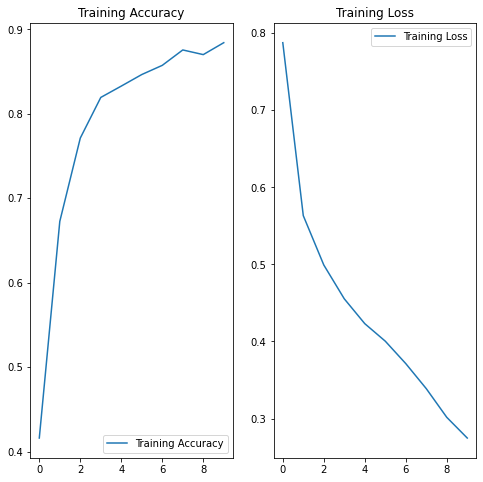

In [23]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()


In [24]:
# Detect Anomalies through this
reconstructions = autoencoder.predict(test_data)
reconstruction_error = np.mean(np.abs(reconstructions - test_data), axis=1)
threshold = np.mean(reconstruction_error) + np.std(reconstruction_error)
anomalies = np.where(reconstruction_error > threshold, 1, 0)

625/625 [==============================] - 0s 442us/step


In [25]:
print(train_labels.shape)

(80000, 2)


In [32]:
classification = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(34,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

classification.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])
history = classification.fit(train_data, train_labels, epochs=10,
                    batch_size=128, verbose=1)


Epoch 1/10
625/625 [==============================] - 1s 863us/step - loss: 0.2694 - accuracy: 0.8965
Epoch 2/10
625/625 [==============================] - 1s 863us/step - loss: 0.0707 - accuracy: 0.9875
Epoch 3/10
625/625 [==============================] - 1s 821us/step - loss: 0.0362 - accuracy: 0.9938
Epoch 4/10
625/625 [==============================] - 1s 815us/step - loss: 0.0379 - accuracy: 0.9953
Epoch 5/10
625/625 [==============================] - 1s 821us/step - loss: 0.0216 - accuracy: 0.9961
Epoch 6/10
625/625 [==============================] - 1s 862us/step - loss: 0.0218 - accuracy: 0.9966
Epoch 7/10
625/625 [==============================] - 1s 826us/step - loss: 0.0133 - accuracy: 0.9971
Epoch 8/10
625/625 [==============================] - 1s 819us/step - loss: 0.0103 - accuracy: 0.9970
Epoch 9/10
625/625 [==============================] - 1s 806us/step - loss: 0.0128 - accuracy: 0.9971
Epoch 10/10
625/625 [==============================] - 1s 849us/step - loss: 0.012

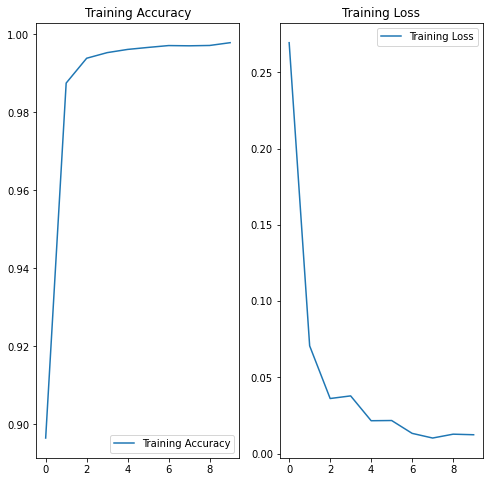

In [33]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [34]:
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)

625/625 [==============================] - 0s 283us/step


In [35]:
# Ensembling module
# Predictions and Anomalies
def majority_voting(labels1, labels2):
    # Combine labels using majority voting
    combined_labels = np.where((labels1 + labels2) > 1, 1, 0)
    return combined_labels


In [43]:
def test_random_id(model1, model2, test_data, test_labels):
    # Choose a random id from the test set
    random_id = np.random.randint(0, len(test_data))
    # Get the corresponding data and label
    data = test_data[random_id]
    label = test_labels[random_id]
    # Reshape the data to match the input shape of the models
    data = data.reshape(1, -1)
    # Make predictions using both models
    predictions1 = model1.predict(data)
    predictions2 = model2.predict(data)
    # Combine the predictions using majority voting
    combined_predictions = majority_voting(predictions1, predictions2)
    # Get the predicted label
    predicted_label = combined_predictions[0]
    # Check if the prediction matches the true label
    if np.all(predicted_label == label):
        accuracy = "Correct"
    else:
        accuracy = "Incorrect"
    # Print the results
    print("Random ID:", random_id)
    print("True label:", label)
    print("Predicted label:", predicted_label)
    print("Accuracy:", accuracy)




test_random_id(autoencoder, classification, test_data, test_labels)


1/1 [==============================] - 0s 13ms/step


ValueError: operands could not be broadcast together with shapes (1,34) (1,2) 